### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

**1**

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [123]:
digits = load_digits()
# Split data into 50% train and 50% test subsets
# X_train, X_test, y_train, y_test = train_test_split(
#     digits.data, digits.target, test_size=0.2, shuffle=False)

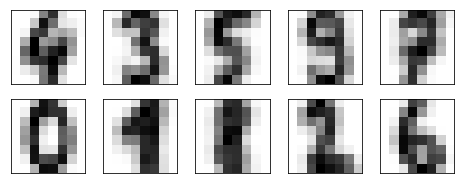

In [206]:
"""
Credit: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
"""
kmeans = KMeans(n_clusters=10, random_state=0)
predicted = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**2**

In [207]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report

In [208]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
labels

array([0, 8, 8, ..., 8, 9, 9], dtype=int32)

In [209]:
# We get a list of the labels
labels_un = [mode(digits.target[(clusters == i)])[0][0] for i in range(10)]
labels_un

[4, 3, 5, 9, 7, 0, 1, 8, 2, 6]

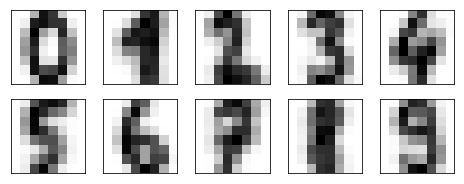

In [210]:
# We zip the labels list with the list of centers
# Then we sort this list of tuples
zipped = zip(labels_un, centers)
zipped = sorted(zipped, key=lambda x: x[0])
sorted_centers = [center[1] for center in zipped]


fig, ax = plt.subplots(2, 5, figsize=(8, 3))
for axi, center in zip(ax.flat, sorted_centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**3**

In [213]:
accuracy_score(digits.target, labels)


0.7935447968836951

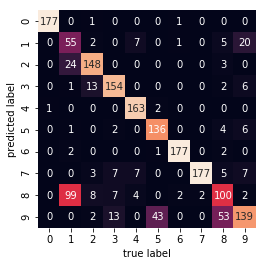

In [214]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [215]:
"""
We check the accuracy % of each predicted label, meaning
how many counts exist for a given label, in a cell that isn't
in the diagonal.
"""

import pandas as pd

labels = []
totals = []
misses = []
accuracies = []
for label in range(len(mat)):
    l = list(mat[label])
    total =  sum(l)
    l.pop(label)
    missed = sum(l)
    accur = (total - missed) / total
    labels.append(label)
    totals.append(total)
    misses.append(missed)
    accuracies.append(accur)
    
predicts = pd.DataFrame({
    "Label": labels,
    "Totals": totals,
    "Misses": misses,
    "Accuracies": accuracies
})
predicts

,Label,Totals,Misses,Accuracies
0,0,178,1,0.994382
1,1,182,127,0.302198
2,2,177,29,0.836158
3,3,183,29,0.841530
4,4,181,18,0.900552
5,5,182,46,0.747253
6,6,181,4,0.977901
7,7,179,2,0.988827
8,8,174,74,0.574713
9,9,180,41,0.772222


In [216]:
predicts.nsmallest(2, 'Accuracies')

,Label,Totals,Misses,Accuracies
1,1,182,127,0.302198
8,8,174,74,0.574713


Our accuracy score is 0.79, or ~80%. This means we've accurately labeled 8 out of 10 clusters in an unsupervised way.

Additionally, we have the following labels that have been mis-predicted more than 20 times: 1, 5 and 8.

This means that 1's were mis-labeled 7 times out of 10, and 5's were mis-labeld nearly 4 times out of 10.


**4**


In [219]:
from sklearn.metrics.cluster import fowlkes_mallows_score

fowlkes_mallows_score(digits.target, clusters)

0.7027346870127681

We see that the FM score is 0.09 percentage points lower than the accuracy_score (AS). As per the sci_kit documentation, we know that that accurary_score is an implementation of the Jaccard Index (JI). The JI, is the quotient of the intersection of two sets, over the resulting set of the same two set's union.
Essentially, which percentage of two sets overlap, and in our case, which percentage of predicted labels match the true labels.

The FM score on the other hand is a representation of the same overlap as the AS, though interpreted by quantifying the gap between the mean centers of the clusters of the predicted labels from the real label values in a geometric context. 

As in, quantifying the gap between the true and predicted values as a "mean" or average distance between two points or difference of area. It does this by calculating the ratio of the true/ideal results as a distance/value, over the percieved distance/value that seperates the distance/value of the cluster. 

It's formula, according to scikit, is FMI = TP / sqrt((TP + FP) * (TP + FN)). 

OR

FMI = TP / sqrt((X) * (Y)); X = TP + FP; Y = TP + FN

Where X and Y are two orthogonal vectors, each along the x and y axes respectively, and the square root of their products, as per Pythagoras, is the quantified distance between the end of these two vectors of similar or differing length. Therefore, one could summarize the FMI as being a quantifying function of how two clusters (the mean centers of the clusters being the ends of the vectors X and Y) are **different**, by gaging the distance that seperates the mean center of these two clusters in 2D space.


Therefore, the difference between AS and FM can be highlighted as being that AS is a single-dimension comparison, on sets or lists, ie, is a value in both sets, or just one.
Whereas the FM score is meant to evaluate on a potentially multi-dimensional context, ie, how much overlap is there between the real and predicted cluster, and in which potential direction is this difference in space so that a potential correction could be made.

This is why we are seeing a difference between our AS, and our FMI. Our AS is simply telling us that our prediction was 80% accurate, in that there is a 80% overlap in values between our real and predicted sets. Whereas our FM score is telling us that in fact, our mean prediction is off by 100 - 70 = 30% on average.


### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.